In [1]:
# Create MNIST data arrays
%run ./generate_mnist_dataset.ipynb

  1%|▏         | 852/60000 [00:00<00:07, 8355.77it/s]

Preprocessing MNIST training data...


 11%|█         | 1059/10000 [00:00<00:00, 10583.78it/s]

Preprocessing MNIST training data...


100%|██████████| 10000/10000 [00:02<00:00, 4570.86it/s]


In [3]:
# Load and prepare the data

import torch
import os
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader
from tqdm import tqdm
from training_data import DataCollection
from PIL import Image
from matplotlib import pyplot as plt

def print_data_infos(data_train, data_test):
    print("Train data length: {0}".format(len(data_train.data)))
    print("Test data length: {0}".format(len(data_test.data)))
    print("Img Shape: {0}".format(data_train.data[0].shape))
    print("Number of Labels: {0}".format(data_train.no_labels))
    
data_all_train = DataCollection()
data_all_test = DataCollection(train=False)

data_ops_train = DataCollection(use_hasy=False, use_mnist=False, own_path='plus-min-div')
data_ops_test = DataCollection(use_hasy=False, use_mnist=False, own_path='plus-min-div', train=False)

data_brckts_train = DataCollection(use_hasy=False, use_mnist=False, own_path='plus-brckts')
data_brckts_test = DataCollection(use_hasy=False, use_mnist=False, own_path='plus-brckts', train=False)

print_data_infos(data_all_train, data_all_test)
print_data_infos(data_ops_train, data_ops_test)
print_data_infos(data_brckts_train, data_brckts_test)


  0%|          | 0/16992 [00:00<?, ?it/s]

No training data for ). Skipping


100%|██████████| 10000/10000 [00:00<00:00, 121282.95it/s]


No training data for ). Skipping
No training data for 0. Skipping
No training data for 1. Skipping
No training data for 2. Skipping
No training data for 3. Skipping
No training data for 4. Skipping
No training data for 5. Skipping
No training data for 6. Skipping
No training data for 7. Skipping
No training data for 8. Skipping
No training data for 9. Skipping
No training data for brckts. Skipping
No training data for ). Skipping
No training data for 0. Skipping
No training data for 1. Skipping
No training data for 2. Skipping
No training data for 3. Skipping
No training data for 4. Skipping
No training data for 5. Skipping
No training data for 6. Skipping
No training data for 7. Skipping
No training data for 8. Skipping
No training data for 9. Skipping
No training data for brckts. Skipping
No training data for ). Skipping
No training data for 0. Skipping
No training data for 1. Skipping
No training data for 2. Skipping
No training data for 3. Skipping
No training data for 4. Skipping


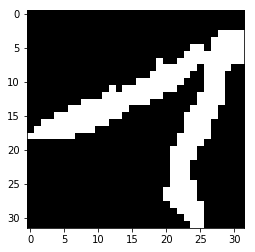

Label: 1


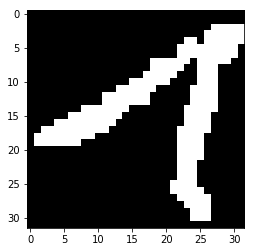

Label: 1


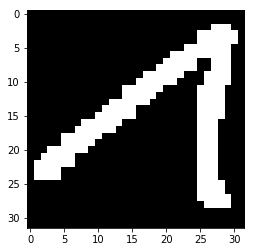

Label: 1


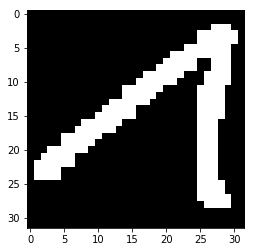

Label: 1


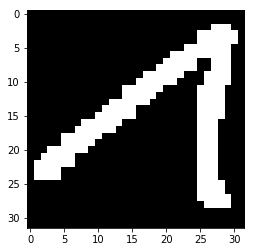

Label: 1


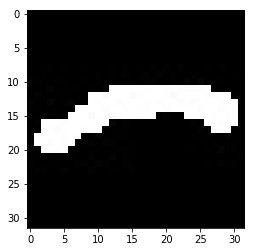

Label: 11


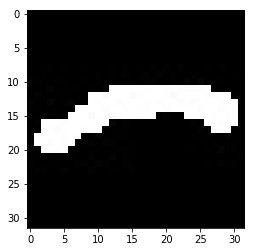

Label: 11


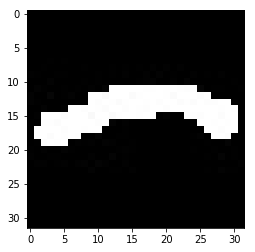

Label: 11


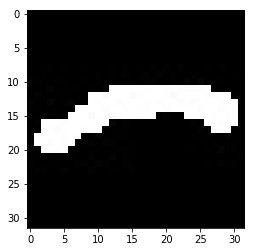

Label: 11


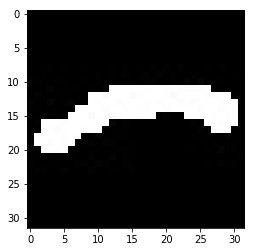

Label: 11


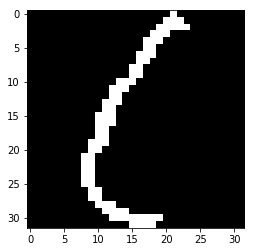

Label: 13


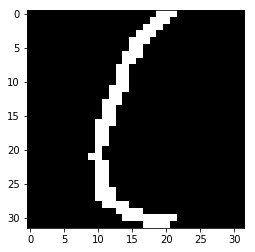

Label: 13


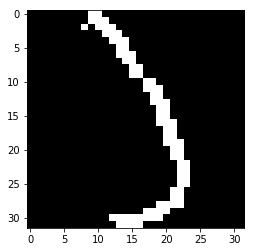

Label: 13


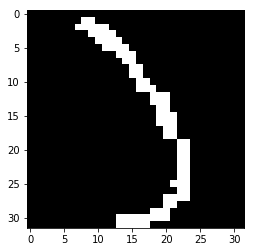

Label: 14


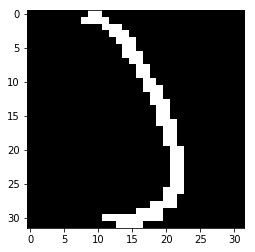

Label: 14


In [5]:


# Plot some images for control

from torchvision import transforms
for i in range(61000, 61005):
    test_img = transforms.ToPILImage()(data_all_train.data[i])
    plt.imshow(test_img, cmap='gray')
    plt.show()
    print("Label:", data_all_train.targets[i])

for i in range(3000, 3005):
    test_img = transforms.ToPILImage()(data_ops_train.data[i])
    plt.imshow(test_img, cmap='gray')
    plt.show()
    print("Label:", data_ops_train.targets[i])
    
for i in range(7000, 7005):
    test_img = transforms.ToPILImage()(data_brckts_train.data[i])
    plt.imshow(test_img, cmap='gray')
    plt.show()
    print("Label:", data_brckts_train.targets[i])

In [2]:
# Declare the network and some utilities

from torchvision import models
from torch.nn import Conv2d


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train(train_loader, test_loader, model_name, print_step, epochs=5):
    model = models.alexnet(num_classes=15)
    model.features[0] = Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    if torch.cuda.is_available():
        model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.8, 0.99), weight_decay=0.001)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        print("Epoch {0}".format(epoch))
        for step, [x_train, y_train] in enumerate(tqdm(train_loader)):
            if torch.cuda.is_available():
                 x_train, y_train = x_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            train_pred = model(x_train)
            loss = criterion(train_pred, y_train)
            loss.backward()
            optimizer.step()
            if step % print_step == 0:
                print('Loss: {}'.format(loss))
        
        acc = calc_accuracy(model, test_loader)
        print("Accuracy: {0}".format(acc))
        if acc > 98:
            torch.save(model.state_dict(), '{0}-{1}.ckpt'.format(model_name,acc))
    print("Accuracy: {0}".format(acc))
    torch.save(model.state_dict(), '{0}.ckpt'.format(model_name))

def calc_accuracy(model, test_loader):
    accuracies = []
    for idx, [x_test, y_test] in enumerate(tqdm(test_loader)):
        if torch.cuda.is_available():
            x_test, y_test = x_test.to(device), y_test.to(device)
        test_pred = model(x_test)
        accuracy = 100 * torch.mean((torch.argmax(test_pred, dim=1) == y_test).float())
        accuracies.append(accuracy.item() if torch.cuda.is_available() else accuracy)
    return np.mean(accuracies)  

train_all_loader = DataLoader(data_all_train, batch_size=16, shuffle=True)
test_all_loader = DataLoader(data_all_test, batch_size=16, shuffle=False)

train_ops_loader = DataLoader(data_ops_train, batch_size=16, shuffle=True)
test_ops_loader = DataLoader(data_ops_test, batch_size=16, shuffle=False)

train_brckts_loader = DataLoader(data_brckts_train, batch_size=16, shuffle=True)
test_brckts_loader = DataLoader(data_brckts_test, batch_size=16, shuffle=False)



In [ ]:
train(train_all_loader, test_all_loader, 'model-all-symbols', 500)
train(train_ops_loader, test_ops_loader, 'model-plus-minus-div', 60)
train(train_brckts_loader, test_brckts_loader, 'model-plus-brackets', 60)

  0%|          | 0/4259 [00:00<?, ?it/s]

Epoch 0


  0%|          | 1/4259 [00:00<32:25,  2.19it/s]

Loss: 2.708343505859375


 12%|█▏        | 501/4259 [05:14<34:45,  1.80it/s]  

Loss: 1.2580705881118774


 24%|██▎       | 1001/4259 [14:32<1:03:55,  1.18s/it]

Loss: 0.10727978497743607


 35%|███▌      | 1501/4259 [22:53<41:48,  1.10it/s]  

Loss: 0.029521822929382324


 47%|████▋     | 2001/4259 [30:25<34:04,  1.10it/s]

Loss: 0.0038171857595443726


 59%|█████▊    | 2501/4259 [38:12<27:58,  1.05it/s]

Loss: 0.10790929943323135


 70%|███████   | 3001/4259 [46:43<28:33,  1.36s/it]

Loss: 0.012806504964828491


 82%|████████▏ | 3501/4259 [55:01<11:06,  1.14it/s]

Loss: 0.012121886014938354


 94%|█████████▍| 4001/4259 [1:03:01<04:05,  1.05it/s]

Loss: 0.017300494015216827


  0%|          | 0/4259 [00:00<?, ?it/s]

Accuracy: 97.23348236083984
Epoch 1


  0%|          | 1/4259 [00:00<59:37,  1.19it/s]

Loss: 0.08350574970245361


 12%|█▏        | 501/4259 [08:19<1:06:46,  1.07s/it]

Loss: 0.20002050697803497


 24%|██▎       | 1001/4259 [16:15<53:37,  1.01it/s] 

Loss: 0.0005107969045639038


 35%|███▌      | 1501/4259 [24:07<40:56,  1.12it/s]  

Loss: 0.0026123225688934326


 47%|████▋     | 2001/4259 [32:06<35:20,  1.06it/s]

Loss: 0.10357918590307236


 59%|█████▊    | 2501/4259 [39:50<26:40,  1.10it/s]

Loss: 0.06995148211717606


 70%|███████   | 3001/4259 [47:08<16:41,  1.26it/s]

Loss: 0.35300710797309875


 82%|████████▏ | 3501/4259 [54:21<15:45,  1.25s/it]

Loss: 0.09422300010919571


 94%|█████████▍| 4001/4259 [1:04:34<04:11,  1.03it/s]

Loss: 0.14568957686424255


  0%|          | 0/4259 [00:00<?, ?it/s]

Accuracy: 95.57356262207031
Epoch 2


  0%|          | 1/4259 [00:00<1:02:11,  1.14it/s]

Loss: 0.00037425756454467773


 12%|█▏        | 501/4259 [07:36<57:51,  1.08it/s]  

Loss: 0.4852687120437622


 24%|██▎       | 1001/4259 [15:43<51:13,  1.06it/s] 

Loss: 0.027386248111724854


 35%|███▌      | 1501/4259 [24:12<42:58,  1.07it/s]  

Loss: 0.1979708969593048


 47%|████▋     | 2001/4259 [31:43<44:10,  1.17s/it]

Loss: 0.0018292814493179321


 59%|█████▊    | 2501/4259 [39:54<1:01:41,  2.11s/it]

Loss: 0.0013107508420944214


 70%|███████   | 3001/4259 [48:02<17:30,  1.20it/s]  

Loss: 0.1647205948829651


 82%|████████▏ | 3501/4259 [55:40<17:05,  1.35s/it]

Loss: 0.3683150112628937


 88%|████████▊ | 3734/4259 [1:00:08<10:45,  1.23s/it]

In [ ]:
acc = calc_accuracy(torch_model)
print("Accuracy: {0}".format(acc))
torch.save(torch_model.state_dict(), 'combined-model-v3.ckpt')